# Analysis of the fluorescence recovery on parasite coats

The script gets its input from a config yml configuration file:
```yaml
filelist: /path/to/filelist.csv
summary: /path/to/results.csv
```
with filelist a csv file with columns 

|Filename| Start time [min]| First frame|
|--------|-----------------|------------|

where Filename column pointing to a TIF image file with a matching -profile.csv file with the columns 

|Frame|Time [min]|Mean Intensity|
|-----|----------|--------------|

Finally, summary is the path to a csv file with the result of the analysis by the imagej macro.

## Load dataset
Open the config.yaml file and load the intensity profile for each file listed in the filelist.

In [1]:
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
from scipy.signal import medfilt
import time

tag = time.strftime('%d%m%y', time.localtime())
print(f'Saving results with tag {tag}')

def madstd(x):
    """Maximum absolute deviation of the standard deviation"""
    return 1.4826 * np.median(np.abs(x-np.median(x)))

def f1(s):             
    return madstd(s.to_frame())
f1.__name__ = 'madstd'
q25 = partial(pd.Series.quantile, q=0.25)
q25.__name__ ='25%'
q50 = partial(pd.Series.quantile, q=0.50)
q50.__name__ ='50%'
q75 = partial(pd.Series.quantile, q=0.75)
q75.__name__ ='75%'
def f2(s):             
    return pd.Series.quantile(s,0.75) -  pd.Series.quantile(s,0.25)
f2.__name__ ='25%-75%'

def resample_intensities(p:pd.DataFrame, x:np.ndarray, metric:str):
    y = np.interp(x, p['Time [min]'], p[metric])
    y0, y1 = p[metric].min(), p[metric].max()    
    z = (y - y0) / (y1 - y0)
    return pd.DataFrame({'Parasite':[p['Parasite'].iloc[0] for k in x], 
                         'Time [min]':x, 
                         metric: y, 
                         f'Normalized {metric}':z})

Saving results with tag 070224


Load the summary.csv table

In [2]:
# Load the configuration file
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

folder = Path(config['summary']).parent

# Load the summary file
summary = pd.read_csv(config['summary'])

# Decode the parasite index 
summary['Parasite'] = summary['Image'].transform(lambda x: int(x.split('_')[0].replace('Parasite','')))

# Order the files
summary.sort_values(by='Parasite', inplace=True, ignore_index=True)

# Drop previous estimate of model parameters
summary.drop(columns=['Time mid point [min]','Time constant [min]', '5%-95% recovery time [min]', 'Intensity amplitude [au]','Intensity offset [au]','Photo-bleaching [min]','R squared'], inplace=True)

summary.head()

,Image,Start time [min],First frame,Image width,Image height,Image slices,Image frames,Image pixel size,Image spacing,Image frame interval,Objective,Camera,Numerical Aperture,Parasite
0,Parasite1_from video on manuscript_211013_GFPR...,60,1,142,142,17,21,0.065091,0.4,29.971338,SR Apo TIRF AC 100xH,Hamamatsu Dual C11440-22C,1.49,1
1,Parasite2_from video on manuscript_211013_GFPR...,60,11,172,150,17,26,0.065091,0.4,29.971338,SR Apo TIRF AC 100xH,Hamamatsu Dual C11440-22C,1.49,2
2,Parasite3_211013_GFPRNF_RHtomato_30min_2min001...,30,1,155,148,13,10,0.065091,0.4,127.162109,SR Apo TIRF AC 100xH,Hamamatsu Dual C11440-22C,1.49,3
3,Parasite4_211013_GFPRNF_RHtomato_30min_2min001...,30,4,126,138,13,7,0.065091,0.4,127.162109,SR Apo TIRF AC 100xH,Hamamatsu Dual C11440-22C,1.49,4
4,Parasite5_231129_23MIN_1min.nd2 - 231129_23MIN...,23,1,42,55,9,16,0.233051,0.7,60.705688,Plan Fluor 40x Oil DIC H N2,Prime 95B A21B203017,1.30,5


Combine all profiles in one dataframe

In [3]:

# Load the filelist in a dataframe
filelist = pd.read_csv(config['filelist'])

# Decode the parasite index
filelist['Parasite'] = filelist['Filename'].transform(lambda x: int(x.split('_')[0].replace('Parasite','')))

# Order the files
filelist.sort_values(by='Parasite', inplace=True, ignore_index=True)

# Define a loading function for the profile files
def load_profile(folder, row):
    path = folder / row['Filename'].replace('.tif','-profile.csv')
    df = pd.read_csv(path)
    df['Parasite'] = row['Parasite']
    # Drop previous estimate of model
    df.drop(columns=['Model'], inplace=True)
    return df
    
# Load the individual intensity profiles from *-profile.csv files saved by the ImageJ macro
profiles = pd.concat([load_profile(folder, row) for row in filelist.iloc], ignore_index=True)

profiles.to_csv(folder/'all profiles.csv')

profiles.head()


,Frame,Time [min],Mean intensity,Fraction,Parasite
0,1,60.499522,109.944005,0.026449,1
1,2,60.999045,110.122265,0.040593,1
2,3,61.498567,110.066081,0.040723,1
3,4,61.998089,110.600591,0.051829,1
4,5,62.497612,111.520249,0.100390,1


In [4]:
t = np.arange(20,120,0.25)
interpolated_int = profiles.groupby('Parasite').apply(partial(resample_intensities,x=t, metric='Mean intensity')).droplevel('Parasite')
interpolated_vol = profiles.groupby('Parasite').apply(partial(resample_intensities,x=t, metric='Fraction')).droplevel('Parasite')

## Erf function model
Re-estimate the parameters from the mean intensity profiles.

In [5]:
figure_folder = folder / f'figure_{tag}_erf'
figure_folder.mkdir(parents=True, exist_ok=True)
print(figure_folder)

/home/jeromeb/work/userdata/Randow_group/anac/parasite coat rnf213/Videos to analyse/figure_070224_erf


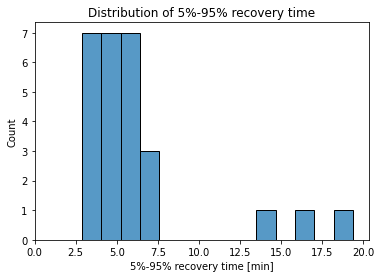

In [6]:
def model_erf(x,a,b,c,d,e):    
    """Error function + exponention"""
    return  a + b * erf((x-c) / d) * np.exp(-x / e)

def initialize_erf_parameters(x,y,alpha=0.2):
    ym = medfilt(y,3)
    a, b = np.percentile(ym, 5), np.percentile(ym, 90)    
    alpha = 0.2
    y0, y1, y2 = a + alpha * (b - a), a + (1-alpha) * (b - a), 0.5*(a+b)
    x0, x1, x2 = 0.0, 0.0, 0.0
    corr = 2 * erfinv(1 - alpha)  
    for i, yi in enumerate(ym):
        if i > 0:  
            if yi > y0 and x0 == 0 :
                x0 = x[i-1] + (y0 - y[i-1]) * (x[i] - x[i-1]) / (yi - y[i-1])
            if yi > y1 and x1 == 0 :
                x1 = x[i-1] + (y1 - y[i-1]) * (x[i] - x[i-1]) / (yi - y[i-1])
            if yi > y2 and x2 == 0 :
                x2 = x[i-1] + (y2 - y[i-1]) * (x[i] - x[i-1]) / (yi - y[i-1])
    x2=(x0+x1)/2
    p = [0.5*(a+b), 0.5*(b - a), x2  , (x1-x0)/corr, 50]
    l = [0.3*(a+b), 0.3*(b - a), x2-1, 0, 10]
    u = [0.6*(a+b), 0.7*(b - a), x2+1, 1e3, 1e9]    
    return {'p0':p, 'bounds':(l,u)}

def fit_erf_model(name, group, metric):
    """Least square fit of the model parameters"""    
    x, y = group['Time [min]'], group[metric]
    x = np.array(x[np.isfinite(y)])
    y = np.array(y[np.isfinite(y)])    
    init = initialize_erf_parameters(x,y)        
    p, cov = curve_fit(model_erf, x, y, **init)        
    return {
        'Parasite': name,
        'Offset [au]': p[0],
        'Amplitude [au]': p[1],
        'Time mid point [min]': p[2],
        'Time constant [min]': p[3],
        'Exponential decay [min]': p[4],        
        '5%-95% recovery time [min]': 2 * erfinv(0.9) * p[3],
        'R2': 1 - np.square(model_erf(x,*p)-y).sum() / np.square(y-y.mean()).sum()
    }

parameters_erf = pd.DataFrame.from_records([fit_erf_model(n,g,'Mean intensity') for n, g in profiles.groupby('Parasite')])
sns.histplot(parameters_erf, x='5%-95% recovery time [min]')
plt.title('Distribution of 5%-95% recovery time');
plt.xlim(0,parameters_erf['5%-95% recovery time [min]'].max()+1)
plt.savefig(figure_folder/'histogram of recovery times.pdf')

Customized statistics

In [7]:
parameters_erf.agg(["count","mean", "std", "min",q25, q50, q75, "max",  f1, f2])


,Parasite,Offset [au],Amplitude [au],Time mid point [min],Time constant [min],Exponential decay [min],5%-95% recovery time [min],R2
count,27.000000,27.000000,27.000000,27.000000,27.000000,2.700000e+01,27.000000,27.000000
mean,14.000000,189.989177,66.066655,56.830112,2.642117,3.827764e+08,6.146025,0.983897
std,7.937254,51.196800,43.870973,19.969041,1.726974,4.360981e+08,4.017242,0.024441
min,1.000000,119.707222,9.741813,29.379228,1.240663,9.544860e+01,2.885998,0.870090
25%,7.500000,155.363338,41.017415,42.187765,1.774495,1.899630e+02,4.127785,0.982531
50%,14.000000,171.073748,58.889151,51.803749,2.139556,1.189072e+08,4.976979,0.990532
75%,20.500000,229.755755,75.411514,68.114827,2.583068,9.999993e+08,6.008667,0.994374
max,27.000000,304.760213,186.775902,102.227980,8.324479,1.000000e+09,19.364189,0.999324
madstd,10.378200,45.576464,27.994129,20.926704,0.683920,1.762917e+08,1.590918,0.007270
25%-75%,13.000000,74.392417,34.394099,25.927062,0.808573,9.999991e+08,1.880882,0.011842


In [8]:
col = '5%-95% recovery time [min]'
outlier_threshold =  parameters_erf[col].median() + 3 * madstd(parameters_erf[col])
print(f'Outliers are > {outlier_threshold} ')
idx = parameters_erf[col] > outlier_threshold
parameters_erf.loc[idx]

Outliers are > 9.749733832083514 


,Parasite,Offset [au],Amplitude [au],Time mid point [min],Time constant [min],Exponential decay [min],5%-95% recovery time [min],R2
11,12,156.325324,61.579055,48.931484,8.324479,1.503706e+02,19.364189,0.985628
12,13,151.342043,34.144651,45.305554,5.810840,5.989027e+07,13.517026,0.986570
16,17,175.650116,60.172524,51.803749,7.306931,1.675726e+02,16.997196,0.971355


 Heatmaps

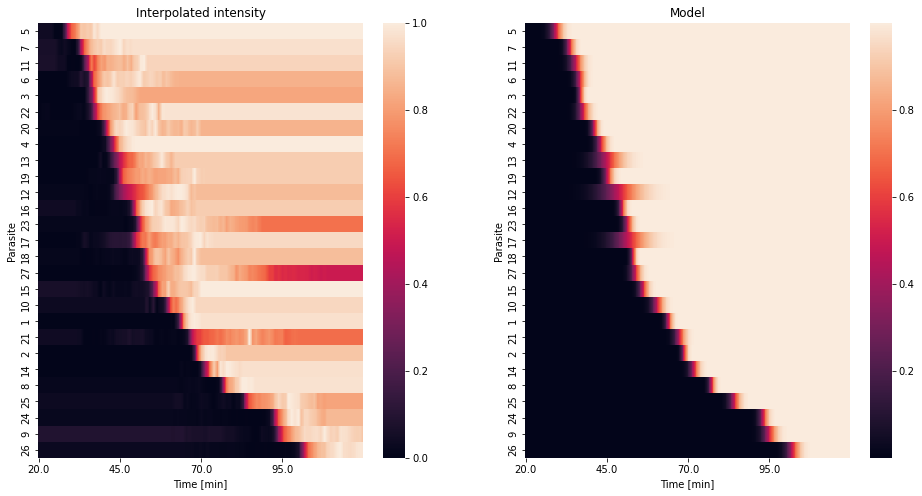

In [9]:

def generate_erf_models(p:pd.DataFrame, x:np.ndarray):
    """Generate models profiles from parameters and time values"""
    yhat = model_erf(x, p[1],p[2],p[3],p[4],p[5])
    return pd.DataFrame({
        'Parasite': [p['Parasite'] for x in range(len(x))],
        'Time [min]' : x,
        'Model [au]': yhat,
        'Normalized model [au]': model_erf(x, 0.5, 0.5, p[3], p[4], 1e6),        
    })


models_erf = pd.concat([generate_erf_models(p,t) for p in parameters_erf.iloc])

order = np.argsort(parameters_erf['Time mid point [min]']).to_numpy() + 1

fig, ax = plt.subplots(1,2,figsize=(16,8))

sns.heatmap(
    interpolated_int.pivot_table('Normalized Mean intensity', 'Time [min]', 'Parasite').transpose().reindex(order),
    xticklabels = 100,
    linewidths = 0.0,     
    rasterized = True,
    vmin=0,
    vmax=1,
    ax=ax[0])
plt.xlim([20,125])
ax[0].set_title('Interpolated intensity')

sns.heatmap(
    models_erf.pivot_table('Normalized model [au]', 'Time [min]', 'Parasite').transpose().reindex(order),
    xticklabels = 100,
    linewidths = 0.0, 
    rasterized = True,
    #vmin=0,
    #vmax=1,
    ax=ax[1])
ax[1].set_title('Model')
plt.savefig(figure_folder/'heatmap.pdf')
plt.show()


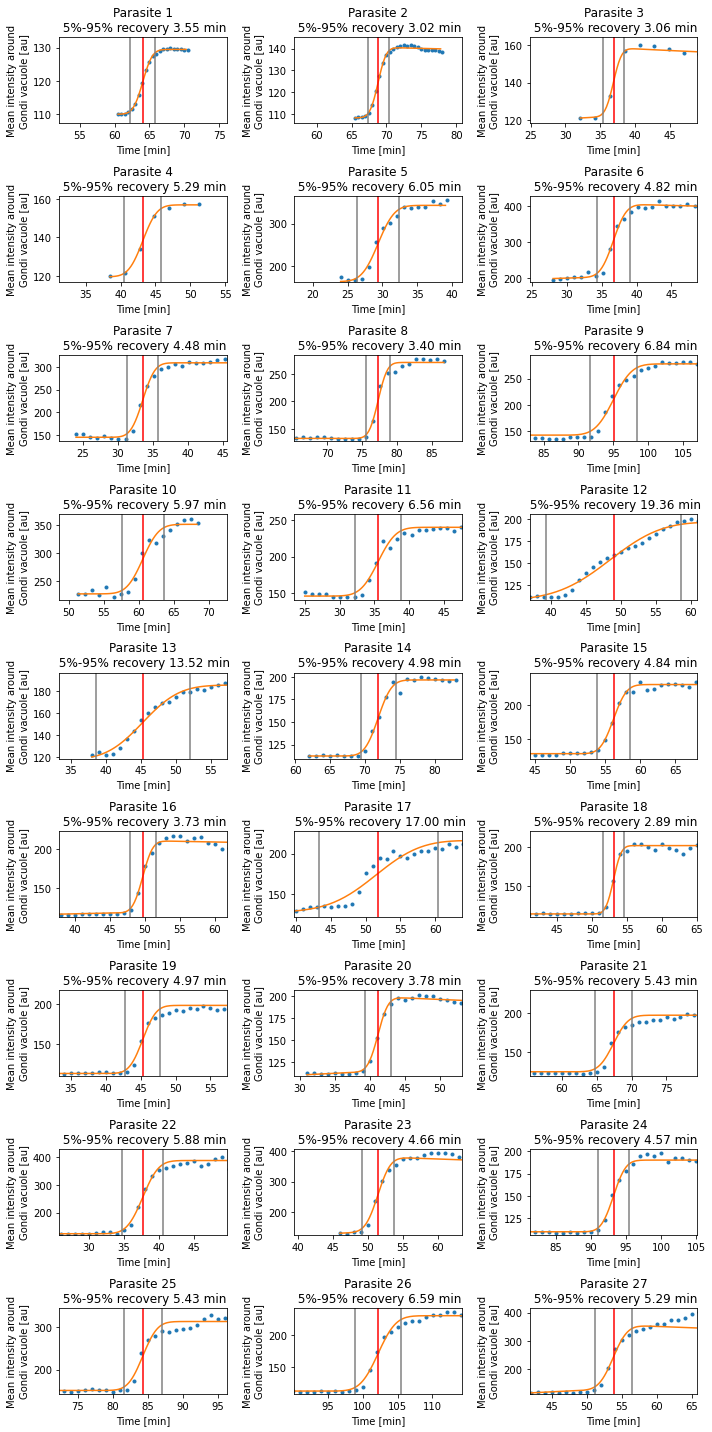

In [10]:
def plot_erf(profile, parameter, ax):    
    ax.plot(profile['Time [min]'], profile['Mean intensity'], '.')
    x = np.arange(profile['Time [min]'].min(), profile['Time [min]'].max(), 0.25)    
    y0, y1 = 0.975*profile['Mean intensity'].min(), 1.025*profile['Mean intensity'].max()
    p = parameter.iloc[0]
    yhat = model_erf(x, *p[1:6])
    ax.plot(x,yhat)
    t2 = p[3]
    dt = p[6]/2    
    ax.plot([t2,t2],[y0,y1],color='red')
    ax.plot([t2+dt,t2+dt],[y0,y1],color='gray')
    ax.plot([t2-dt,t2-dt],[y0,y1],color='gray')
    pid = parameter["Parasite"].item()
    ax.set_title(f'Parasite {pid}\n 5%-95% recovery {2*dt:.2f} min')
    ax.set_xlim([t2-12, t2+12])
    ax.set_ylim(y0,y1)
    ax.set_xlabel('Time [min]')
    ax.set_ylabel('Mean intensity around\nGondi vacuole [au]')
    
fig,ax = plt.subplots(9,3,figsize=(10,20))
for p in parameters_erf['Parasite']:
    plot_erf(profiles[profiles['Parasite']==p], parameters_erf[parameters_erf['Parasite']==p],ax=ax.ravel()[p-1])
fig.tight_layout()
plt.savefig(figure_folder/f'intensity for all parasites.pdf',  bbox_inches='tight')


Save all profiles as individual graph

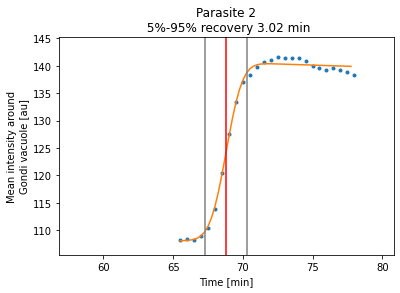

In [11]:
for p in [1,2]:
    plt.clf()
    plot_erf(profiles[profiles['Parasite']==p], parameters_erf[parameters_erf['Parasite']==p],ax=plt.gca())            
    plt.savefig(figure_folder/f'intensity parasite {p}.pdf',  bbox_inches='tight')

Export all data into an MS Excel spreadsheet.

In [12]:
with pd.ExcelWriter(figure_folder/'Parasite coat recovery data.xlsx') as xls:
    summary.to_excel(xls,sheet_name='Info',index=False)
    parameters_erf.to_excel(xls,sheet_name='Model parameters',index=False)
    parameters_erf.agg(["count","mean", "std", "min",q25, q50, q75, "max",  f1, f2]).to_excel(xls,sheet_name='Statistics')
    for n,g in profiles.groupby('Parasite'):
        g.reset_index().drop(columns=['index','Parasite']).to_excel(xls,sheet_name=f'Parasite {n}',index=False)

## Exponential model

In [13]:
figure_folder = folder / f'figure_{tag}_exp'
figure_folder.mkdir(parents=True, exist_ok=True)

In [14]:

def model_exp(x,a,b,c,d,e):
    """Exponential x Error function model"""
    #return a + b * (0.5+0.5*erf((x - c) / e)) * ( 1 - np.exp(-(x - c) / d))
    return a + b * np.maximum(0, 1 - np.exp(-(x - c) / d)) * np.exp(-e*x)

def initialize_exp_parameters(x,y):
    ym = medfilt(y,3)
    a, b = ym.min(), ym.max()
    alpha = 0.2
    y0, y1 = a + alpha * (b - a), a + (1-alpha) * (b - a)
    x0, x1 = 0.0, 0.0 
    for i, yi in enumerate(ym):  
        if yi > y0 and x0 == 0:
            x0 = x[i-1] + (y0-y[i-1]) * (x[i] - x[i-1]) / (y[i] - y[i-1])
        if yi > y1 and x1 == 0:
            x1 = x[i-1] + (y1-y[i-1]) * (x[i] - x[i-1]) / (y[i] - y[i-1])
    p = [a, b - a, x0, (x1 - x0) / 2,0]
    l = [0.9 * a - 0.1 * b, 0.75*(b-a), x0 - 1, 0,0]
    u = [0.9 * a + 0.1 * b, 1.25*(b-a), x0 + 1, 1000,1]    
    return {'p0':p, 'bounds':(l,u)}

def fit_exp(name, group, metric):
    """Least square fit of the model parameters"""
    x, y = group['Time [min]'], group[metric]
    x = np.array(x[np.isfinite(y)])
    y = np.array(y[np.isfinite(y)])
    init = initialize_exp_parameters(x,y)    
    p, cov = curve_fit(model_exp, x, y, **init)    
    return {    
        'Parasite': name,
        'offset': p[0],
        'amplitude': p[1],        
        'start [min]': p[2],
        'time [min]': p[3],        
        'bleaching [min^-1]': p[4],
        '90% completion time [min]': -np.log(0.1) * p[3],
        'R2': 1 - np.square(model_exp(x,*p)-y).sum() / np.square(y-y.mean()).sum()
    }

p1 = pd.DataFrame.from_records([fit_exp(n,g,'Fraction') for n, g in profiles.groupby('Parasite')])
p1.columns = pd.MultiIndex.from_tuples([('Fraction',c) for c in p1.columns])
p2 = pd.DataFrame.from_records([fit_exp(n,g,'Mean intensity') for n, g in profiles.groupby('Parasite')])
p2.columns = pd.MultiIndex.from_tuples([('Mean intensity',c) for c in p2.columns])
parameters_exp = pd.merge(p1.drop(columns=('Fraction','Parasite')),p2.drop(columns=('Mean intensity','Parasite')),left_index=True,right_index=True)
parameters_exp['Parasite'] = p1['Fraction','Parasite']
parameters_exp.describe()


Fraction                                                       \
             offset  amplitude start [min] time [min] bleaching [min^-1]   
count  2.700000e+01  27.000000   27.000000  27.000000       2.700000e+01   
mean   2.870644e-02   0.948678   55.047643   1.905889       1.714119e-03   
std    3.190444e-02   0.184949   19.923227   1.231647       1.938828e-03   
min   -3.179614e-11   0.452665   27.686412   0.792073       1.397720e-32   
25%    5.450686e-03   0.860395   41.121657   1.123193       1.157646e-17   
50%    1.263737e-02   0.944884   50.196927   1.566998       6.210345e-04   
75%    4.335009e-02   1.063565   66.670441   2.081786       3.479733e-03   
max    1.110244e-01   1.250000   99.960120   6.699801       5.600845e-03   

                                           Mean intensity              \
      90% completion time [min]         R2         offset   amplitude   
count                 27.000000  27.000000      27.000000   27.000000   
mean                   4.388472   0.993715     133.492700  138.227116   
std                    2.835971   0.007538      28.628059   85.815103   
min                    1.823816   0.967440     109.728041   24.616700   
25%                    2.586249   0.992067     114.416583   85.836832   
50%                    3.608146   0.996982     124.882341  110.125244   
75%                    4.793490   0.998625     143.078078  172.287360   
max                   15.426862   0.999205     230.026831  359.319642   

                                                                           \
      start [min] time [min] bleaching [min^-1] 90% completion time [min]   
count   27.000000  27.000000       2.700000e+01                 27.000000   
mean    55.012644   2.444907       2.446556e-03                  5.629606   
std     20.065883   1.596180       2.437477e-03                  3.675341   
min     27.590880   0.767088       7.563133e-29                  1.766286   
25%     41.033028   1.441544       3.409680e-19                  3.319277   
50%     50.193742   2.103156       2.991859e-03                  4.842696   
75%     66.747826   2.826216       4.034259e-03                  6.507602   
max    100.153101   8.180026       6.884319e-03                 18.835207   

                   Parasite  
              R2             
count  27.000000  27.000000  
mean    0.988729  14.000000  
std     0.016279   7.937254  
min     0.911461   1.000000  
25%     0.988531   7.500000  
50%     0.992289  14.000000  
75%     0.994385  20.500000  
max     0.999082  27.000000

Distribution of completion time

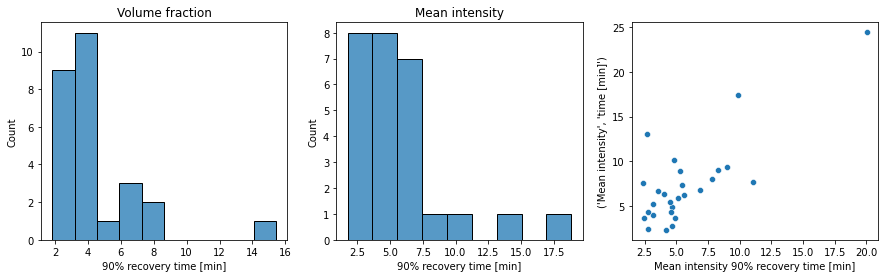

In [15]:
plt.figure(figsize=(15,4))
plt.subplot(131)
sns.histplot(x=parameters_exp['Fraction','90% completion time [min]'])
plt.title('Volume fraction')
plt.xlabel('90% recovery time [min]')
plt.subplot(132)
sns.histplot(x=parameters_exp['Mean intensity','90% completion time [min]'])
plt.title('Mean intensity')
plt.xlabel('90% recovery time [min]')
plt.subplot(133)
sns.scatterplot(x=2.99*parameters_exp['Fraction','time [min]'], y=2.99*parameters_exp['Mean intensity','time [min]'])
plt.xlabel('Volume fraction 90% recovery time [min]')
plt.xlabel('Mean intensity 90% recovery time [min]')
plt.savefig(figure_folder / 'distribution of recovery time.pdf')


In [16]:
parameters_exp.agg(["count","mean", "std", "min",q25, q50, q75, "max",  f1, f2])

Fraction                                                       \
               offset  amplitude start [min] time [min] bleaching [min^-1]   
count    2.700000e+01  27.000000   27.000000  27.000000       2.700000e+01   
mean     2.870644e-02   0.948678   55.047643   1.905889       1.714119e-03   
std      3.190444e-02   0.184949   19.923227   1.231647       1.938828e-03   
min     -3.179614e-11   0.452665   27.686412   0.792073       1.397720e-32   
25%      5.450686e-03   0.860395   41.121657   1.123193       1.157646e-17   
50%      1.263737e-02   0.944884   50.196927   1.566998       6.210345e-04   
75%      4.335009e-02   1.063565   66.670441   2.081786       3.479733e-03   
max      1.110244e-01   1.250000   99.960120   6.699801       5.600845e-03   
madstd   1.785268e-02   0.161776   20.249084   0.737383       9.207457e-04   
25%-75%  3.789940e-02   0.203171   25.548784   0.958593       3.479733e-03   

                                             Mean intensity              \
        90% completion time [min]         R2         offset   amplitude   
count                   27.000000  27.000000      27.000000   27.000000   
mean                     4.388472   0.993715     133.492700  138.227116   
std                      2.835971   0.007538      28.628059   85.815103   
min                      1.823816   0.967440     109.728041   24.616700   
25%                      2.586249   0.992067     114.416583   85.836832   
50%                      3.608146   0.996982     124.882341  110.125244   
75%                      4.793490   0.998625     143.078078  172.287360   
max                     15.426862   0.999205     230.026831  359.319642   
madstd                   1.697888   0.002940      16.882056   40.335817   
25%-75%                  2.207242   0.006559      28.661495   86.450528   

                                                                             \
        start [min] time [min] bleaching [min^-1] 90% completion time [min]   
count     27.000000  27.000000       2.700000e+01                 27.000000   
mean      55.012644   2.444907       2.446556e-03                  5.629606   
std       20.065883   1.596180       2.437477e-03                  3.675341   
min       27.590880   0.767088       7.563133e-29                  1.766286   
25%       41.033028   1.441544       3.409680e-19                  3.319277   
50%       50.193742   2.103156       2.991859e-03                  4.842696   
75%       66.747826   2.826216       4.034259e-03                  6.507602   
max      100.153101   8.180026       6.884319e-03                 18.835207   
madstd    20.911767   0.992475       4.435730e-03                  2.285259   
25%-75%   25.714798   1.384672       4.034259e-03                  3.188325   

                     Parasite  
                R2             
count    27.000000  27.000000  
mean      0.988729  14.000000  
std       0.016279   7.937254  
min       0.911461   1.000000  
25%       0.988531   7.500000  
50%       0.992289  14.000000  
75%       0.994385  20.500000  
max       0.999082  27.000000  
madstd    0.005539  10.378200  
25%-75%   0.005854  13.000000

In [17]:
metric = 'Mean intensity'
col = '90% completion time [min]'
outlier_threshold =  parameters_exp[metric,col].median() + 3 * madstd(parameters_exp[metric,col])
print(f'Outliers are > {outlier_threshold} ')
idx = parameters_exp[metric,col] > outlier_threshold
parameters_exp.loc[idx]

Outliers are > 11.69847137750714 


Fraction                                                      \
      offset amplitude start [min] time [min] bleaching [min^-1]   
11  0.010211  1.114020   42.591582   6.699801           0.002190   
12  0.079838  0.988777   42.168134   3.304092           0.005048   

                                       Mean intensity                          \
   90% completion time [min]        R2         offset   amplitude start [min]   
11                 15.426862  0.994146     112.798657  111.400102   42.922496   
12                  7.607953  0.988272     122.947770   82.919108   41.761103   

                                                                     Parasite  
   time [min] bleaching [min^-1] 90% completion time [min]        R2           
11   8.180026           0.003406                 18.835207  0.983037       12  
12   5.822318           0.003642                 13.406383  0.992996       13

Display all profiles

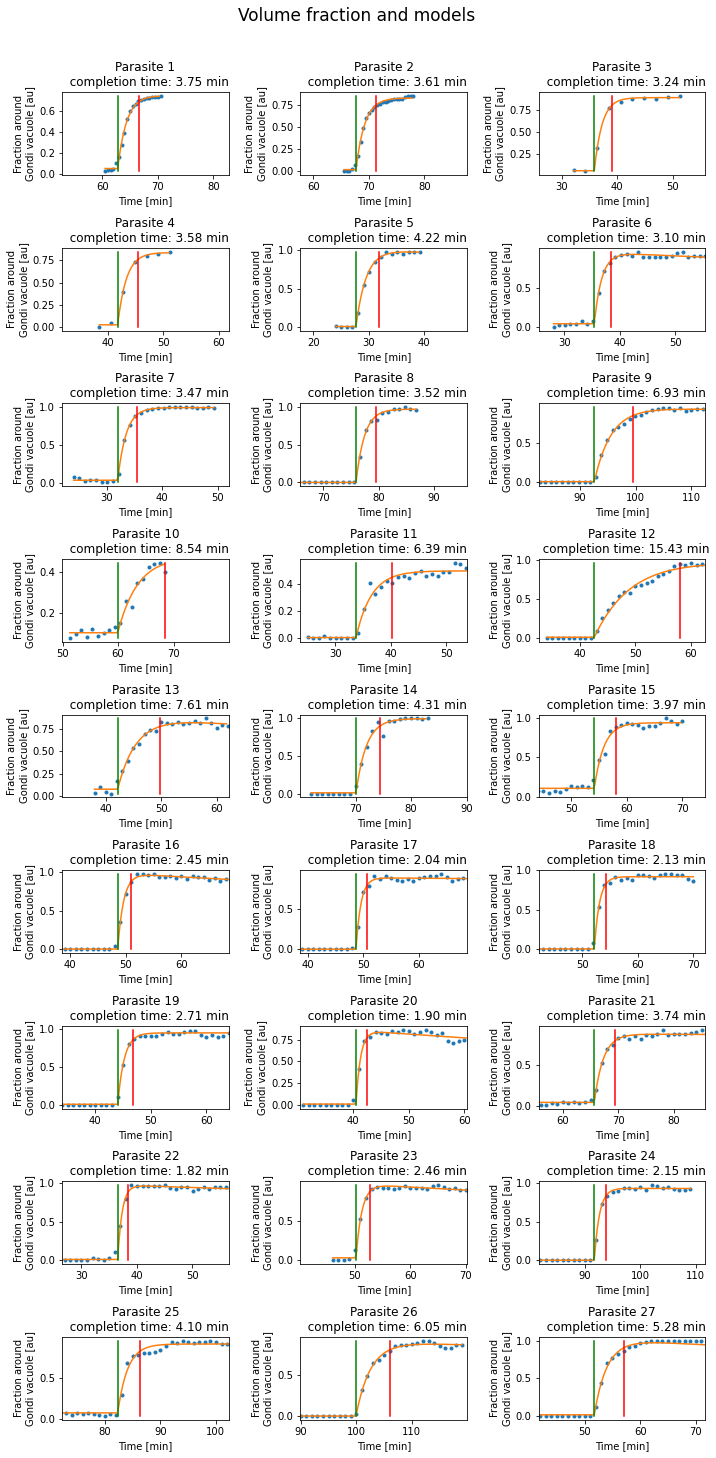

In [18]:
def plot_exp(profile, parameter, metric, ax, setrange=False):    
    ax.plot(profile['Time [min]'], profile[metric], '.')
    x = np.arange(profile['Time [min]'].min(), profile['Time [min]'].max(), 0.25)    
    y0, y1 = profile[metric].min(), profile[metric].max()
    p = parameter.iloc[0]
    yhat = model_exp(x, p[metric,'offset'], p[metric,'amplitude'], p[metric,'start [min]'], p[metric,'time [min]'],p[metric, 'bleaching [min^-1]'])
    ax.plot(x,yhat)    
    t0 = p[metric, 'start [min]']    
    dt =  p[metric,'90% completion time [min]']
    t2 = t0 + dt
    ax.plot([t0,t0],[y0,y1], color='green')    
    ax.plot([t2,t2],[y0,y1], color='red')
    pid = parameter["Parasite"].item()
    ax.set_title(f'Parasite {pid}\n  completion time: {dt:.2f} min')
    if setrange:
        ax.set_xlim(t0-10, t0+20)
        #ax.set_ylim(0.95 * y0 - 0.05 * y1 , 1.05 * y1 - 0.05 * y0)
        ax.set_xlabel('Time [min]')
    ax.set_ylabel(f'{metric} around\nGondi vacuole [au]')
    
fig,ax = plt.subplots(9,3,figsize=(10,20))
for p in parameters_exp['Parasite']:
    plot_exp(profiles[profiles['Parasite']==p], parameters_exp[parameters_exp['Parasite']==p],'Fraction', ax=ax.ravel()[p-1], setrange=True)
plt.suptitle('Volume fraction and models', y = 1.01, fontsize=17)
fig.tight_layout()
plt.savefig(figure_folder/'volume fraction for all parasites.pdf')

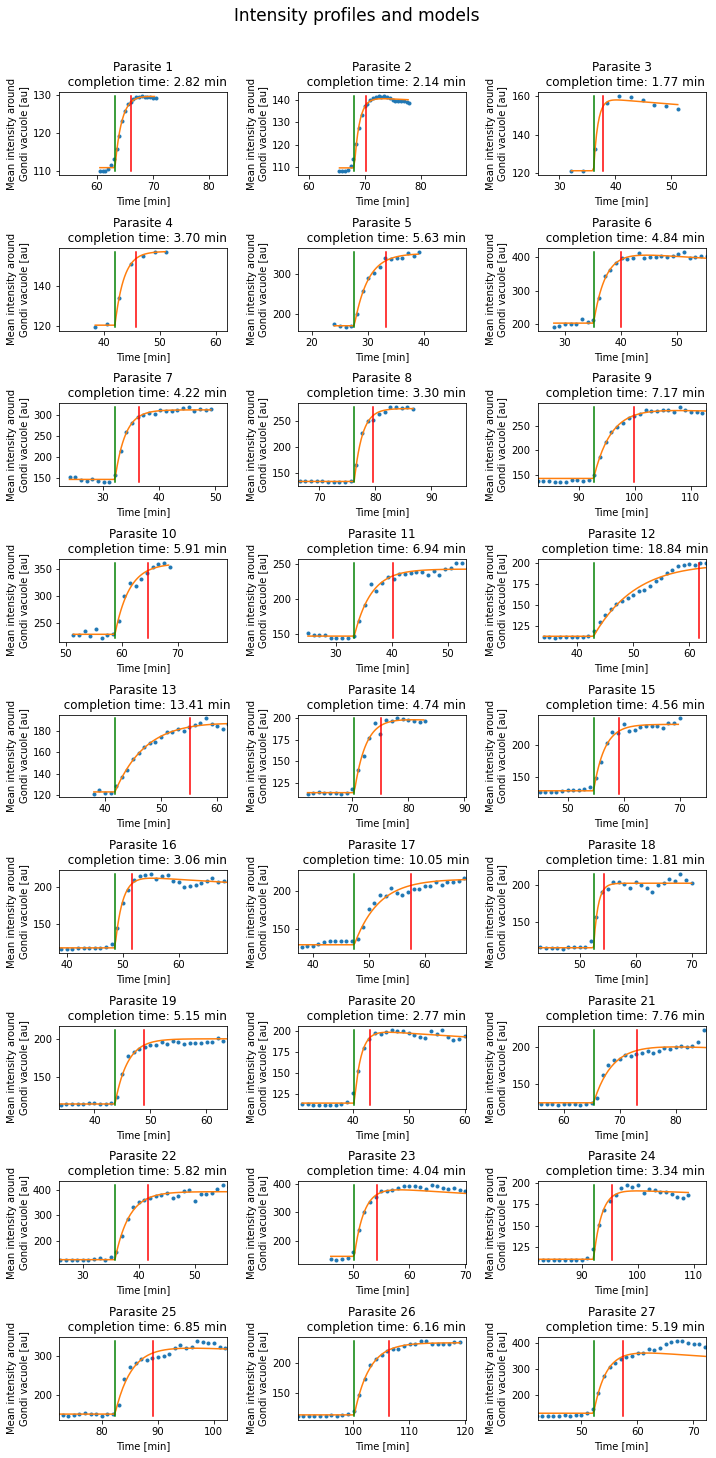

In [19]:
fig,ax = plt.subplots(9,3,figsize=(10,20))
for p in parameters_exp['Parasite']:
    plot_exp(profiles[profiles['Parasite']==p], parameters_exp[parameters_exp['Parasite']==p],'Mean intensity', ax=ax.ravel()[p-1],setrange=True)
plt.suptitle('Intensity profiles and models', y = 1.01, fontsize=17)
fig.tight_layout()
plt.savefig(figure_folder/'intensity profile for all parasites.pdf')


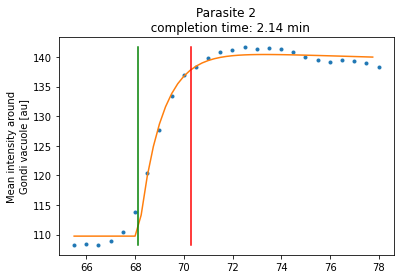

In [20]:
for p in [1,2]:
    plt.clf()
    plot_exp(profiles[profiles['Parasite']==p], parameters_exp[parameters_exp['Parasite']==p],'Mean intensity',ax=plt.gca())            
    plt.savefig(figure_folder/f'intensity parasite {p}.pdf',  bbox_inches='tight')

Heatmaps

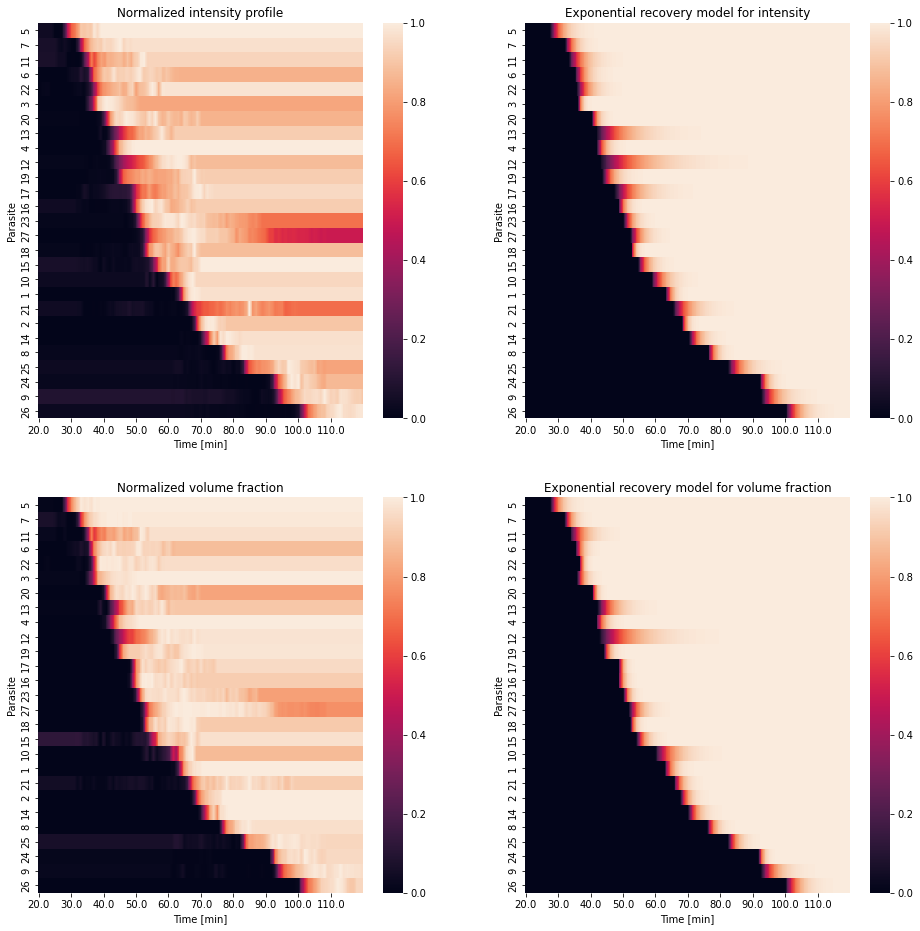

In [21]:

def generate_exp_models(p:pd.DataFrame, x:np.ndarray, metric:str):
    """Generate models profiles from parameters and time values"""    
    yhat = model_exp(x, p[metric, 'offset'], p[metric,'amplitude'], p[metric,'start [min]'], p[metric, 'time [min]'],p[metric, 'bleaching [min^-1]'])           
    return pd.DataFrame({
        'Parasite': [p['Parasite'].item() for x in range(len(x))],
        'Time [min]' : x,
        'Model [au]': yhat,
        'Normalized model [au]': model_exp(x, 0, 1, p[metric,'start [min]'], p[metric,'time [min]'],0)   ,        
    })

models_exp_int = pd.concat([generate_exp_models(p,t,'Mean intensity') for p in parameters_exp.iloc])
models_exp_vol = pd.concat([generate_exp_models(p,t,'Fraction') for p in parameters_exp.iloc])

fig, ax = plt.subplots(2,2,figsize=(16,16))
order = np.argsort(parameters_exp['Mean intensity','start [min]']).to_numpy() + 1

sns.heatmap(
    interpolated_int.pivot_table('Normalized Mean intensity', 'Time [min]', 'Parasite').transpose().reindex(order),
    xticklabels = 40,
    linewidths = 0.0,     
    rasterized = True,
    vmin=0,
    vmax=1,
    ax=ax[0,0])
plt.xlim([20,125])
ax[0,0].set_title('Normalized intensity profile')

sns.heatmap(
    models_exp_int.pivot_table('Normalized model [au]', 'Time [min]', 'Parasite').transpose().reindex(order),
    xticklabels = 40,
    linewidths = 0.0, 
    rasterized = True,
    vmin=0,
    vmax=1,
    ax=ax[0,1])
ax[0,1].set_title('Exponential recovery model for intensity')

sns.heatmap(
    interpolated_vol.pivot_table('Normalized Fraction', 'Time [min]', 'Parasite').transpose().reindex(order),
    xticklabels = 40,
    linewidths = 0.0,     
    rasterized = True,
    vmin=0,
    vmax=1,
    ax=ax[1,0])
plt.xlim([20,125])
ax[1,0].set_title('Normalized volume fraction')

sns.heatmap(
    models_exp_vol.pivot_table('Normalized model [au]', 'Time [min]', 'Parasite').transpose().reindex(order),
    xticklabels = 40,
    linewidths = 0.0, 
    rasterized = True,
    vmin=0,
    vmax=1,
    ax=ax[1,1])
ax[1,1].set_title('Exponential recovery model for volume fraction')
plt.savefig(figure_folder/'heatmap.pdf')
plt.show()


Export all to excel

In [22]:
with pd.ExcelWriter(figure_folder/'Parasite coat recovery data.xlsx') as xls:
    summary.to_excel(xls,sheet_name='Info',index=False)
    parameters_exp.to_excel(xls,sheet_name='Model parameters')
    parameters_exp.agg(["count","mean", "std", "min",q25, q50, q75, "max",  f1, f2]).to_excel(xls,sheet_name='Statistics')
    for n,g in profiles.groupby('Parasite'):
        g.reset_index().drop(columns=['index','Parasite']).to_excel(xls,sheet_name=f'Parasite {n}',index=False)

## Convolution and exponential model

In [23]:
figure_folder = folder / f'figure_{tag}_convexp'
figure_folder.mkdir(parents=True, exist_ok=True)

In [24]:
from scipy.signal import convolve
from scipy.optimize import curve_fit

def gaussian(x,s):    
    c = 0.5 * (x.max() + x.min())
    f = np.exp(-0.5 * np.square((x - c) / s))
    if f.sum() > 0:
        return f / f.sum()
    else :
        print(s)
        return f

def conv(f,h):
    m = h.shape[-1]    
    fp = np.pad(f, m, 'edge')
    z = convolve(fp, h,'same')
    return z[m:2*m]

def model_convexp(x,a,b,c,d,e,f):
    """Exponential x Error function model"""
    #return a + b * (0.5+0.5*erf((x - c) / e)) * ( 1 - np.exp(-(x - c) / d))
    y = a + b * np.maximum(0, 1 - np.exp(-(x - c) / (d+e))) * np.exp(-x/f)
    h = gaussian(x, e)
    z = conv(y,h)
    return z

def initialize_convexp_parameters(x,y):    
    ym = y
    a, b = ym.min(), ym.max()
    alpha = 0.2
    y0, y1 = a + alpha * (b - a), a + (1-alpha) * (b - a)
    x0, x1 = 0.0, 0.0 
    for i, yi in enumerate(ym):  
        if yi > y0 and x0 == 0:
            x0 = x[i-1] + (y0-y[i-1]) * (x[i] - x[i-1]) / (y[i] - y[i-1])
        if yi > y1 and x1 == 0:
            x1 = x[i-1] + (y1-y[i-1]) * (x[i] - x[i-1]) / (y[i] - y[i-1])
    
    p = [a, b - a, x0, (x1 - x0), 0.2, 100]    
    l = [0.9 * a - 0.1 * b, 0.75*(b-a), x0 - 1, 0.1*(x1-x0),0.01,50]
    u = [0.9 * a + 0.1 * b, 1.25*(b-a), x0 + 1, 10*(x1-x0),2,1e9]        
    return {'p0':p, 'bounds':(l,u)}

def fit_convexp(name, group, metric):
    """Least square fit of the model parameters"""
    x, y = group['Time [min]'], group[metric]
    x = np.array(x[np.isfinite(y)])
    y = np.array(y[np.isfinite(y)]) 
    if len(y) > 10:
        y = medfilt(y, 5)
    from scipy.interpolate import CubicSpline
    cs = CubicSpline(x,y)    
    xi = np.arange(x.min(), x.max(), 0.1)
    y = cs(xi)    
    x = xi
    init = initialize_convexp_parameters(x,y)    
    p, cov = curve_fit(model_convexp, x, y, **init)      
    return {    
        'Parasite': name,
        'offset': p[0],
        'amplitude': p[1],
        'start [min]': p[2],
        'time [min]': p[3],
        'smooth [min]': p[4],
        'bleaching [min]': p[5],
        '90% completion time [min]': -np.log(0.1) * (p[3]+p[4]) + 2.3 * p[4],
        'R2': 1 - np.square(model_convexp(x,*p)-y).sum() / np.square(y-y.mean()).sum()
    }

p1 = pd.DataFrame.from_records([fit_convexp(n,g,'Fraction') for n, g in profiles.groupby('Parasite')])
p1.columns = pd.MultiIndex.from_tuples([('Fraction',c) for c in p1.columns])
p2 = pd.DataFrame.from_records([fit_convexp(n,g,'Mean intensity') for n, g in profiles.groupby('Parasite')])
p2.columns = pd.MultiIndex.from_tuples([('Mean intensity',c) for c in p2.columns])
parameters_convexp = pd.merge(p1.drop(columns=('Fraction','Parasite')),p2.drop(columns=('Mean intensity','Parasite')),left_index=True,right_index=True)
parameters_convexp['Parasite'] = p1['Fraction','Parasite']
print(1 - p2['Mean intensity', 'R2'].mean(), 1-p2['Mean intensity', 'R2'].min())
parameters_convexp.describe()


0.007940561502094545 0.08894991050127687


Fraction                                                 \
          offset  amplitude start [min] time [min] smooth [min]   
count  27.000000  27.000000   27.000000  27.000000    27.000000   
mean    0.020121   0.954288   55.036437   1.202732     0.553104   
std     0.031263   0.197198   19.943937   1.277803     0.451097   
min    -0.029598   0.445554   27.621793   0.161135     0.090149   
25%     0.000179   0.854304   40.862965   0.368844     0.247383   
50%     0.006325   0.965086   50.093269   0.757092     0.427201   
75%     0.036712   1.072237   66.644080   1.543884     0.633666   
max     0.106044   1.255635  100.010728   6.263212     1.857485   

                                                           Mean intensity  \
      bleaching [min] 90% completion time [min]         R2         offset   
count    2.700000e+01                 27.000000  27.000000      27.000000   
mean     3.534194e+08                  5.315102   0.997022     132.777275   
std      4.747222e+08                  2.685948   0.003992      28.443785   
min      1.846792e+02                  2.997640   0.980744     108.552892   
25%      3.358696e+02                  3.571517   0.995335     113.633948   
50%      1.143451e+03                  4.472701   0.998642     124.574251   
75%      9.875742e+08                  6.127176   0.999309     141.870369   
max      1.000000e+09                 15.519866   0.999734     228.800550   

                                                                       \
        amplitude start [min] time [min] smooth [min] bleaching [min]   
count   27.000000   27.000000  27.000000    27.000000    2.700000e+01   
mean   136.901358   55.013097   1.667397     0.627111    3.151603e+08   
std     84.328647   20.069574   1.435327     0.421603    4.566694e+08   
min     24.577336   27.524472   0.155561     0.016348    1.343203e+02   
25%     85.774790   40.982016   0.322463     0.343159    2.846936e+02   
50%    109.456804   50.123247   1.489313     0.547816    3.541931e+02   
75%    171.656579   66.775137   2.382255     0.828583    9.999999e+08   
max    356.148273  100.142443   5.831296     2.000000    1.000000e+09   

                                             Parasite  
      90% completion time [min]         R2             
count                 27.000000  27.000000  27.000000  
mean                   6.725659   0.992059  14.000000  
std                    4.011803   0.016979   7.937254  
min                    3.183539   0.911050   1.000000  
25%                    4.676554   0.991840   7.500000  
50%                    6.054062   0.997230  14.000000  
75%                    7.023689   0.998103  20.500000  
max                   22.632224   0.999681  27.000000

Distribution of recovery

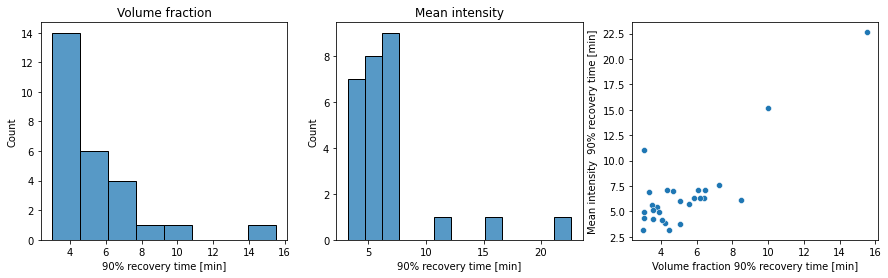

In [25]:
plt.figure(figsize=(15,4))
plt.subplot(131)
sns.histplot(x=parameters_convexp['Fraction','90% completion time [min]'])
plt.title('Volume fraction')
plt.xlabel('90% recovery time [min]')
plt.subplot(132)
sns.histplot(x=parameters_convexp['Mean intensity','90% completion time [min]'])
plt.title('Mean intensity')
plt.xlabel('90% recovery time [min]')
plt.subplot(133)
sns.scatterplot(x=parameters_convexp['Fraction','90% completion time [min]'], y=parameters_convexp['Mean intensity','90% completion time [min]'])
plt.xlabel('Volume fraction 90% recovery time [min]')
plt.ylabel('Mean intensity  90% recovery time [min]')
plt.savefig(figure_folder / 'distribution of recovery time.pdf')


In [26]:
metric = 'Mean intensity'
col = '90% completion time [min]'
outlier_threshold =  parameters_convexp[metric,col].median() + 3 * madstd(parameters_convexp[metric,col])
print(f'Outliers are > {outlier_threshold} ')
idx = parameters_convexp[metric,col] > outlier_threshold
parameters_convexp.loc[idx]

Outliers are > 10.799275452496547 


Fraction                                                                \
      offset amplitude start [min] time [min] smooth [min] bleaching [min]   
11  0.010742  1.059033   42.545485   6.263212     0.238624      659.063591   
12  0.034150  0.966559   42.203315   0.636817     1.857485      255.786488   
16 -0.000118  0.933581   48.635182   0.465153     0.432150     1143.451434   

                                       Mean intensity                          \
   90% completion time [min]        R2         offset   amplitude start [min]   
11                 15.519866  0.994713     111.314015  111.760744   42.849010   
12                 10.015556  0.998512     121.995367   82.067609   41.746068   
16                  3.060061  0.999152     130.087963   85.184261   47.510049   

                                                                      \
   time [min] smooth [min] bleaching [min] 90% completion time [min]   
11   5.831296     2.000000    3.120591e+02                 22.632224   
12   4.215135     1.198073    2.875905e+02                 15.219940   
16   3.737546     0.526939    1.000000e+09                 11.031299   

             Parasite  
          R2           
11  0.985220       12  
12  0.997680       13  
16  0.986995       17

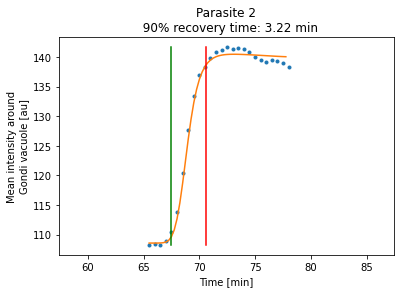

In [27]:
def plot_convexp(profiles, parameters, parasite, metric, ax, setrange=False):    
    pidx = profiles['Parasite']==parasite    
    ax.plot(profiles.loc[pidx,'Time [min]'], profiles.loc[pidx,metric], '.')
    x = np.array(profiles.loc[pidx,'Time [min]'])
    x = np.arange(x.min(),x.max(),0.25)
    y0, y1 = profiles.loc[pidx,metric].min(), profiles.loc[pidx,metric].max()
    qidx = parameters['Parasite']==parasite    
    ax.plot(x,model_convexp(x, *parameters.loc[qidx, metric].iloc[0,:6]))
    t0 = parameters.loc[qidx, metric]['start [min]'].item() - 2.3 / 2 *parameters.loc[qidx, metric]['smooth [min]'].item()
    dt = parameters.loc[qidx, metric]['90% completion time [min]'].item()
    t2 = t0 + dt
    ax.plot([t0,t0],[y0,y1], color='green')    
    ax.plot([t2,t2],[y0,y1], color='red')    
    ax.set_title(f'Parasite {parasite}\n  90% recovery time: {dt:.2f} min')
    if setrange:
        ax.set_xlim(t0-10, t0+20)    
    ax.set_xlabel('Time [min]')
    ax.set_ylabel(f'{metric} around\nGondi vacuole [au]')
    
plot_convexp(profiles, parameters_convexp, 2, 'Mean intensity', ax=plt.gca(), setrange=True)


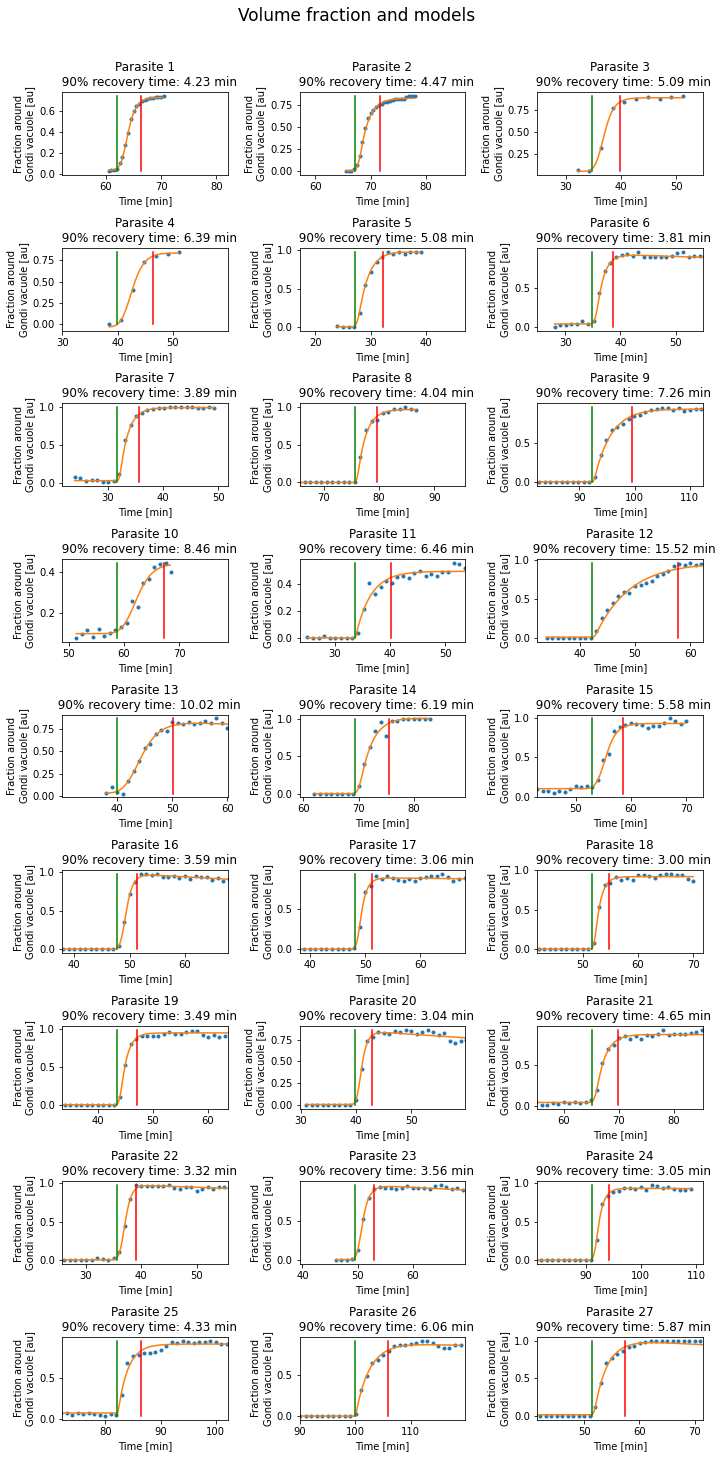

In [28]:
fig,ax = plt.subplots(9,3,figsize=(10,20))
for p in parameters_convexp['Parasite']:
    plot_convexp(profiles, parameters_convexp, p,'Fraction', ax=ax.ravel()[p-1], setrange=True)
plt.suptitle('Volume fraction and models', y = 1.01, fontsize=17)
fig.tight_layout()
plt.savefig(figure_folder/'volume fraction for all parasites.pdf')

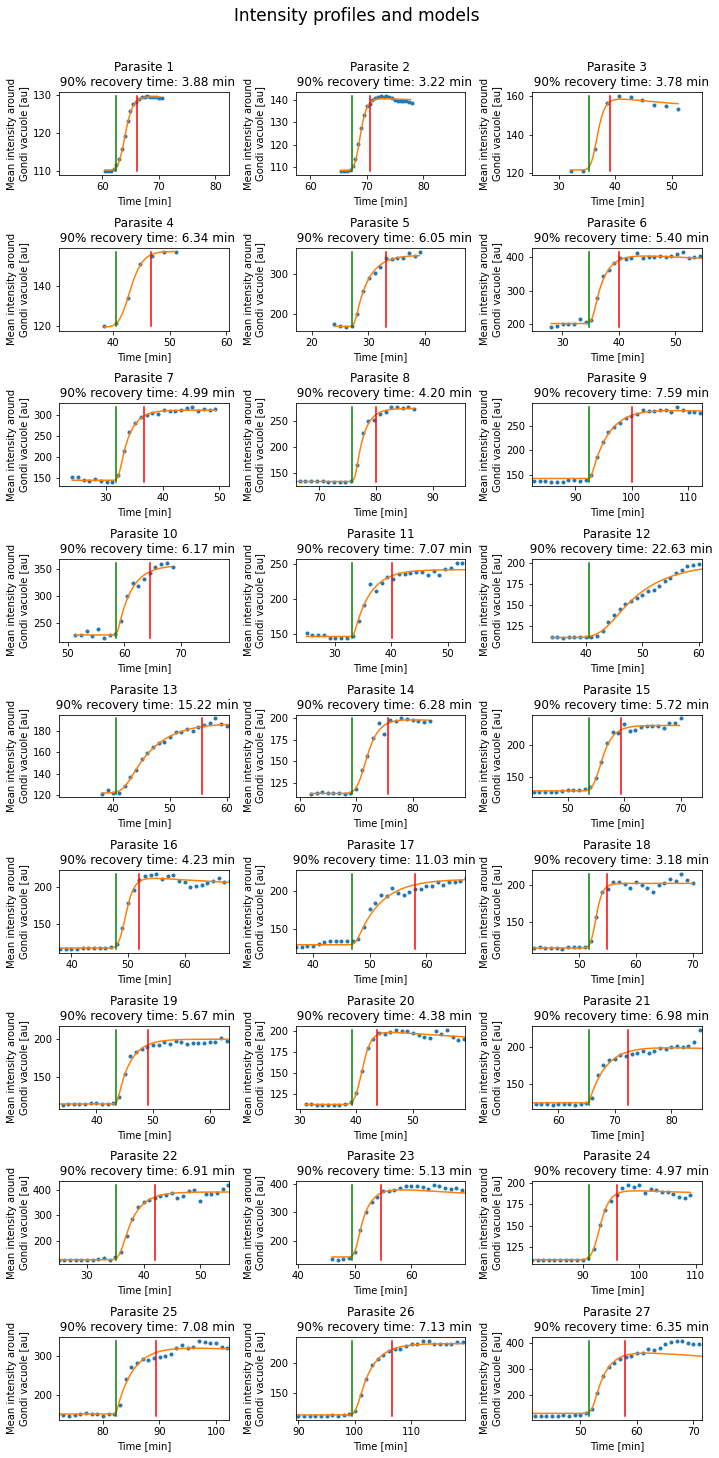

In [29]:
fig,ax = plt.subplots(9,3,figsize=(10,20))
for p in parameters_convexp['Parasite']:
    plot_convexp(profiles, parameters_convexp, p,'Mean intensity', ax=ax.ravel()[p-1],setrange=True)
plt.suptitle('Intensity profiles and models', y = 1.01, fontsize=17)
fig.tight_layout()
plt.savefig(figure_folder/'intensity for all parasites.pdf')

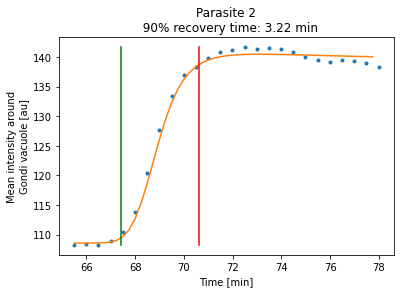

In [30]:
for p in [1,2]:
    plt.clf()
    plot_convexp(profiles, parameters_convexp, p,'Mean intensity',ax=plt.gca())            
    plt.savefig(figure_folder/f'intensity parasite {p}.pdf',  bbox_inches='tight')

Heatmaps

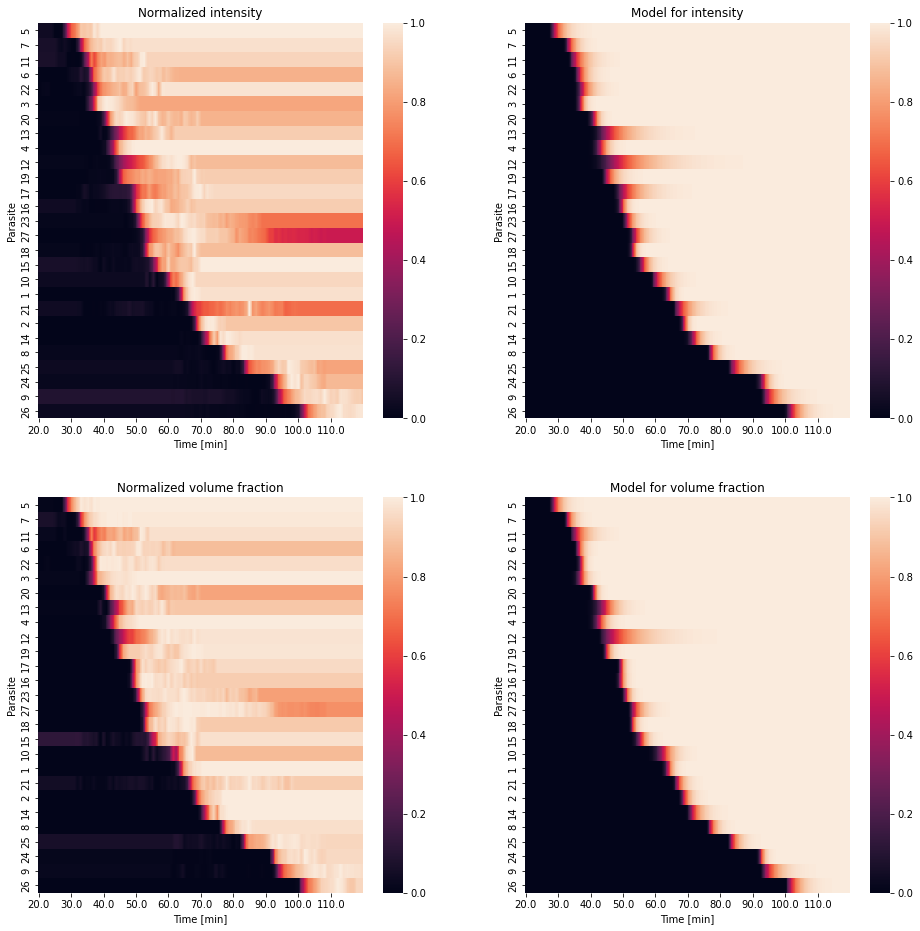

In [31]:
def generate_convexp(p:pd.DataFrame, x:np.ndarray, metric:str):
    """Generate models profiles from parameters and time values"""         
    return pd.DataFrame({
        'Parasite': [p['Parasite'].item() for x in range(len(x))],
        'Time [min]' : x,
        'Model [au]': model_convexp(x, *p[metric][:6]),
        'Normalized model [au]': model_convexp(x, 0, 1, *p[metric][2:5],1e6),        
    })

models_convexp_int = pd.concat([generate_convexp(p,t,'Mean intensity') for p in parameters_convexp.iloc])
models_convexp_vol = pd.concat([generate_convexp(p,t,'Fraction') for p in parameters_convexp.iloc])

fig, ax = plt.subplots(2,2,figsize=(16,16))
order = np.argsort(parameters_convexp['Mean intensity','start [min]']).to_numpy() + 1

sns.heatmap(
    interpolated_int.pivot_table('Normalized Mean intensity', 'Time [min]', 'Parasite').transpose().reindex(order),
    xticklabels = 40,
    linewidths = 0.0,     
    rasterized = True,
    vmin=0,
    vmax=1,
    ax=ax[0,0])
plt.xlim([20,125])
ax[0,0].set_title('Normalized intensity')

sns.heatmap(
    models_convexp_int.pivot_table('Normalized model [au]', 'Time [min]', 'Parasite').transpose().reindex(order),
    xticklabels = 40,
    linewidths = 0.0, 
    rasterized = True,
    vmin=0,
    vmax=1,
    ax=ax[0,1])
ax[0,1].set_title('Model for intensity')

sns.heatmap(
    interpolated_vol.pivot_table('Normalized Fraction', 'Time [min]', 'Parasite').transpose().reindex(order),
    xticklabels = 40,
    linewidths = 0.0,     
    rasterized = True,
    vmin=0,
    vmax=1,
    ax=ax[1,0])
plt.xlim([20,125])
ax[1,0].set_title('Normalized volume fraction')

sns.heatmap(
    models_convexp_vol.pivot_table('Normalized model [au]', 'Time [min]', 'Parasite').transpose().reindex(order),
    xticklabels = 40,
    linewidths = 0.0, 
    rasterized = True,
    vmin=0,
    vmax=1,
    ax=ax[1,1])
ax[1,1].set_title('Model for volume fraction')

plt.savefig(figure_folder/'heatmap.pdf')
plt.show()

Export all data to excel

In [32]:
with pd.ExcelWriter(figure_folder/'Parasite coat recovery data.xlsx') as xls:
    summary.to_excel(xls,sheet_name='Info',index=False)
    parameters_convexp.to_excel(xls,sheet_name='Model parameters')
    parameters_convexp.agg(["count","mean", "std", "min",q25, q50, q75, "max",  f1, f2]).to_excel(xls,sheet_name='Statistics')
    for n,g in profiles.groupby('Parasite'):
        g.reset_index().drop(columns=['index','Parasite']).to_excel(xls,sheet_name=f'Parasite {n}',index=False)